### LangChain Framework (Prompt + Tools + Flow(Graph).)



In [1]:
cd ..

/home/vule/projects/learn_agent


In [2]:
from dotenv import load_dotenv
_ = load_dotenv()

In [3]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.sqlite import SqliteSaver

from src.key import tavily_api_key, openai_api_key

from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [4]:
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [5]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

<img src="/home/vule/projects/learn_agent/images/graph_flow.png" width="500"/>

In [6]:
import json


class Agent:
    """A class that implements an agent capable of using tools and language models in a graph-based workflow."""

    def __init__(self, model, tools, system="", checkpointer=None):
        """Initialize the agent with a model, tools, and optional system message.
        
        Args:
            model: The language model to use
            tools: List of tools available to the agent
            system: Optional system message to prepend to conversations
        """
        self.system = system
        # Create state graph to manage workflow
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        # Add conditional routing based on whether action is needed
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(checkpointer=checkpointer)
        # Create mapping of tool names to tool objects
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        """Check if the last message contains any tool calls that need to be executed.
        
        Args:
            state: Current state containing message history
        Returns:
            bool: True if there are tool calls to execute
        """
        # print state in json format indent 2
        print("exists_action input", state)
        result = state['messages'][-1]
        print("exists_action input", result)
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        """Call the language model with the current conversation history.
        
        Args:
            state: Current state containing message history
        Returns:
            dict: Updated state with model's response
        """
        messages = state['messages']
        print("call_openai messages input", messages)
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        print('call_openai output', message)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        """Execute any tool calls requested by the model.
        
        Args:
            state: Current state containing message history
        Returns:
            dict: Updated state with results of tool executions
        """
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!", results)
        return {'messages': results}

In [7]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-4o-mini-2024-07-18", api_key=openai_api_key)  #reduce inference cost
abot = Agent(model, [tool], system=prompt)

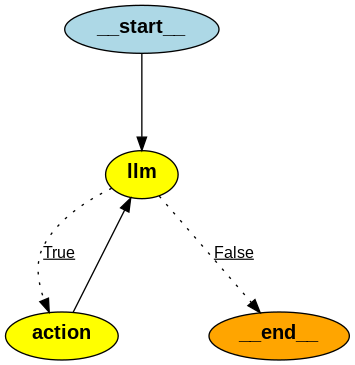

In [8]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [9]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})
print(result)

call_openai messages input [HumanMessage(content='What is the weather in sf?', additional_kwargs={}, response_metadata={})]
call_openai output content='' additional_kwargs={'tool_calls': [{'id': 'call_SC0j1kg5vmBAWhH8YKEO5YHv', 'function': {'arguments': '{"query":"current weather San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 151, 'total_tokens': 173, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-517a662a-7c33-4172-a63a-d3c1e53c8a05-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather San Francisco'}, 'id': 'call_SC0j1kg5vmBAWhH8YKEO5YH

In [10]:
result

{'messages': [HumanMessage(content='What is the weather in sf?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_SC0j1kg5vmBAWhH8YKEO5YHv', 'function': {'arguments': '{"query":"current weather San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 151, 'total_tokens': 173, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-517a662a-7c33-4172-a63a-d3c1e53c8a05-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather San Francisco'}, 'id': 'call_SC0j1kg5vmBAWhH8YKEO5YHv', 'type': 'tool

In [11]:
for m in result['messages']:
    print(type(m), m)


<class 'langchain_core.messages.human.HumanMessage'> content='What is the weather in sf?' additional_kwargs={} response_metadata={}
<class 'langchain_core.messages.ai.AIMessage'> content='' additional_kwargs={'tool_calls': [{'id': 'call_SC0j1kg5vmBAWhH8YKEO5YHv', 'function': {'arguments': '{"query":"current weather San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 151, 'total_tokens': 173, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-517a662a-7c33-4172-a63a-d3c1e53c8a05-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather San Francisco'},

In [12]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

call_openai messages input [HumanMessage(content='What is the weather in SF and LA?', additional_kwargs={}, response_metadata={})]
call_openai output content='' additional_kwargs={'tool_calls': [{'id': 'call_LTSgnxGGIhh2wIDvD9SawBYH', 'function': {'arguments': '{"query": "current weather San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_yMtS0jcYURpe46Lkj6WynHh4', 'function': {'arguments': '{"query": "current weather Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 59, 'prompt_tokens': 153, 'total_tokens': 212, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-

In [13]:
print(result['messages'][-1].content)

Here is the current weather for San Francisco and Los Angeles:

### San Francisco:
- **Temperature**: 8.3°C (46.9°F)
- **Condition**: Fog
- **Wind**: 2.2 mph (3.6 kph) from the South-Southeast
- **Humidity**: 86%
- **Visibility**: 16 km (9 miles)

### Los Angeles:
- **Temperature**: 11.7°C (53.1°F)
- **Condition**: Clear
- **Wind**: 2.5 mph (4.0 kph) from the Northeast
- **Humidity**: 59%
- **Visibility**: 16 km (9 miles)

Feel free to ask if you need more information!


In [14]:
for m in result['messages']:
    print(type(m), m)

<class 'langchain_core.messages.human.HumanMessage'> content='What is the weather in SF and LA?' additional_kwargs={} response_metadata={}
<class 'langchain_core.messages.ai.AIMessage'> content='' additional_kwargs={'tool_calls': [{'id': 'call_LTSgnxGGIhh2wIDvD9SawBYH', 'function': {'arguments': '{"query": "current weather San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_yMtS0jcYURpe46Lkj6WynHh4', 'function': {'arguments': '{"query": "current weather Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 59, 'prompt_tokens': 153, 'total_tokens': 212, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'too

### Handle multiple threads

In [15]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""
model = ChatOpenAI(model="gpt-4o-mini-2024-07-18", api_key=openai_api_key)
abot = Agent(model, [tool], system=prompt, checkpointer=memory)

In [16]:
messages = [HumanMessage(content="Whats the weather in SF?")]
thread = {"configurable": {"thread_id": "2"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

call_openai messages input [HumanMessage(content='Whats the weather in SF?', additional_kwargs={}, response_metadata={})]
call_openai output content='' additional_kwargs={'tool_calls': [{'id': 'call_M2fm6jbkmJWyU1DjEIlhosrj', 'function': {'arguments': '{"query":"current weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 150, 'total_tokens': 173, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-1ab93ba8-cee0-4ad3-a335-df412061553a-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_M2fm6jbkmJWyU1DjEIl

In [17]:
messages = [HumanMessage(content="How about LA?")]
thread = {"configurable": {"thread_id": "2"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

call_openai messages input [HumanMessage(content='Whats the weather in SF?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_M2fm6jbkmJWyU1DjEIlhosrj', 'function': {'arguments': '{"query":"current weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 150, 'total_tokens': 173, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1ab93ba8-cee0-4ad3-a335-df412061553a-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_M2fm6jbkmJWyU1DjEIlhosrj

In [18]:
from pprint import pprint

messages = [HumanMessage(content="Which one is warmer?")]
thread = {"configurable": {"thread_id": "1"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        pprint(v, width=80, depth=2)


call_openai messages input [HumanMessage(content='Which one is warmer?', additional_kwargs={}, response_metadata={})]
call_openai output content='Could you please provide more context? Are you asking about two specific locations, temperatures, or something else?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 149, 'total_tokens': 172, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None} id='run-306da45b-9e50-4290-965b-76b6c2756bed-0' usage_metadata={'input_tokens': 149, 'output_tokens': 23, 'total_tokens': 172, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
exists_action input {'messages': [

### Human in the Loop

In [19]:
from uuid import uuid4
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage

"""
In previous examples we've annotated the `messages` state key
with the default `operator.add` or `+` reducer, which always
appends new messages to the end of the existing messages array.

Now, to support replacing existing messages, we annotate the
`messages` key with a customer reducer function, which replaces
messages with the same `id`, and appends them otherwise.
"""
def reduce_messages(left: list[AnyMessage], right: list[AnyMessage]) -> list[AnyMessage]:
    # assign ids to messages that don't have them
    for message in right:
        if not message.id:
            message.id = str(uuid4())
    # merge the new messages with the existing messages
    merged = left.copy()
    for message in right:
        for i, existing in enumerate(merged):
            # replace any existing messages with the same id
            if existing.id == message.id:
                merged[i] = message
                break
        else:
            # append any new messages to the end
            merged.append(message)
    return merged

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], reduce_messages]

In [20]:
class Agent:
    def __init__(self, model, tools, system="", checkpointer=None):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges("llm", self.exists_action, {True: "action", False: END})
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(
            checkpointer=checkpointer,
            interrupt_before=["action"]
        )
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def exists_action(self, state: AgentState):
        print(state)
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [21]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""
abot = Agent(model, [tool], system=prompt, checkpointer=memory)

In [22]:
messages = [HumanMessage(content="Whats the weather in SF?")]
thread = {"configurable": {"thread_id": "1"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [HumanMessage(content='Which one is warmer?', additional_kwargs={}, response_metadata={}), AIMessage(content='Could you please provide more context? Are you asking about two specific locations, temperatures, or something else?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 149, 'total_tokens': 172, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None}, id='run-306da45b-9e50-4290-965b-76b6c2756bed-0', usage_metadata={'input_tokens': 149, 'output_tokens': 23, 'total_tokens': 172, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='Whats the weather in SF?', ad

In [23]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Which one is warmer?', additional_kwargs={}, response_metadata={}), AIMessage(content='Could you please provide more context? Are you asking about two specific locations, temperatures, or something else?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 149, 'total_tokens': 172, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None}, id='run-306da45b-9e50-4290-965b-76b6c2756bed-0', usage_metadata={'input_tokens': 149, 'output_tokens': 23, 'total_tokens': 172, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='Whats th

In [24]:
abot.graph.get_state(thread).next

('action',)

In [25]:
messages = [HumanMessage("Whats the weather in LA?")]
thread = {"configurable": {"thread_id": "2"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)
while abot.graph.get_state(thread).next:
    print("\n", abot.graph.get_state(thread),"\n")
    _input = input("proceed?")
    if _input != "y":
        print("aborting")
        break
    for event in abot.graph.stream(None, thread):
        for v in event.values():
            print(v)

{'messages': [HumanMessage(content='Whats the weather in SF?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_M2fm6jbkmJWyU1DjEIlhosrj', 'function': {'arguments': '{"query":"current weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 150, 'total_tokens': 173, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1ab93ba8-cee0-4ad3-a335-df412061553a-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_M2fm6jbkmJWyU1DjEIlhosrj', 'type': 'to